# Imports

In [147]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle
import lightkurve as lk
from astropy.io import fits

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [148]:
%matplotlib inline

In [149]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [150]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=22233480
epoch_tess = ufloat(2459396.409578, 0.00075457105)
period_tess = ufloat(7.4463033768041, 0.000023020093)
depth_tess = ufloat(4045.7241784744, 128.28719)
duration_tess = ufloat(2.0033137761697, 0.15890975)
radius_tess = ufloat(2.4048644350425, 0.3086393)
insolation_tess = 5.6286113934149

stmass_tess = ufloat(0.363996, 0.0201927)
strad_tess = ufloat(0.375859, 0.0111301)

# RV reading

In [151]:
lbl_gl514 = pd.read_table('./data/lbl_toi4438_gl514/lbl_TOI4438_GL514.rdb', sep=None, engine='python', header=0)
lbl_gl699 = pd.read_table('./data/lbl_toi4438_gl699/lbl_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699 = pd.read_table('./data/lbl_toi4438_gl699/lbl2_TOI4438_GL699_drift.rdb', sep=None, engine='python', header=0)
lbl_toi4438 = pd.read_table('./data/lbl_toi4438_toi4438/lbl_TOI4438_TOI4438.rdb', sep=None, engine='python', header=0)

lbl2_gl514_new = pd.read_table('./data/new_montreal/lbl2_TOI4438_GL514_bervzp.rdb', sep=None, engine='python', header=0)
lbl_gl514_new = pd.read_table('./data/new_montreal/lbl_TOI4438_GL514_bervzp.rdb', sep=None, engine='python', header=0)
lbl2_gl699_new = pd.read_table('./data/new_montreal/lbl2_TOI4438_GL699_bervzp.rdb', sep=None, engine='python', header=0)

lbl2_gl699_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_GL905.rdb', sep=None, engine='python', header=0)
lbl2_toi4438_car = pd.read_table('./data/lbl2_carmona/lbl2_TOI4438_TOI4438.rdb', sep=None, engine='python', header=0)

carmenes = pd.read_table('./data/carmenes_data/carmenes.rdb', sep=None, engine='python', header=0)
# substract 2400000 to the BJD time
carmenes['rjd'] = carmenes['rjd'] - 2400000
#names = ['lbl_gl514', 'lbl_gl699', 'lbl_toi4438']
names = ['carmenes', 'lbl2_gl699_new']

star_name = 'toi4438'

In [152]:
carmenes.columns

Index(['rjd', 'vrad', 'svrad'], dtype='object')

In [153]:
print(len(lbl_gl514), len(lbl_gl699), len(lbl_toi4438), len(lbl2_gl699_car), len(lbl2_gl905_car), len(lbl2_toi4438_car))
print(len(lbl_gl514_new), len(lbl2_gl514_new), len(lbl2_gl699))

197 197 197 51 51 51
199 51 51


In [154]:
#datasets = list([lbl_gl514, lbl_gl699, lbl_toi4438])
datasets = list([carmenes, lbl2_gl699])

In [155]:
lbl2_gl699['vrad']

0    -35086.827534
1    -35076.070907
2    -35074.872079
3    -35076.845974
4    -35075.970461
5    -35076.034337
6    -35078.428564
7    -35075.212159
8    -35079.187417
9    -35080.959591
10   -35075.135855
11   -35071.463218
12   -35073.239180
13   -35067.196830
14   -35072.833354
15   -35069.161415
16   -35066.720551
17   -35084.074366
18   -35079.779918
19   -35076.652190
20   -35099.415102
21   -35076.754139
22   -35075.082554
23   -35073.134823
24   -35067.437691
25   -35061.879325
26   -35067.201507
27   -35068.532009
28   -35068.365763
29   -35077.119517
30   -35073.046989
31   -35077.054956
32   -35076.421875
33   -35078.406914
34   -35070.267532
35   -35061.489643
36   -35073.220808
37   -35074.448328
38   -35077.265702
39   -35084.739587
40   -35081.903480
41   -35075.264883
42   -35079.272589
43   -35080.931739
44   -35093.187367
45   -35093.983675
46   -35081.713051
47   -35080.809597
48   -35082.496695
49   -35073.897650
50   -35069.385180
Name: vrad, dtype: float64

In [156]:
np.median(lbl2_gl699['vrad'])

-35076.03433674281

In [157]:
for i, data in enumerate(datasets):
    print(np.median(data['vrad']))

-0.245
-35076.03433674281


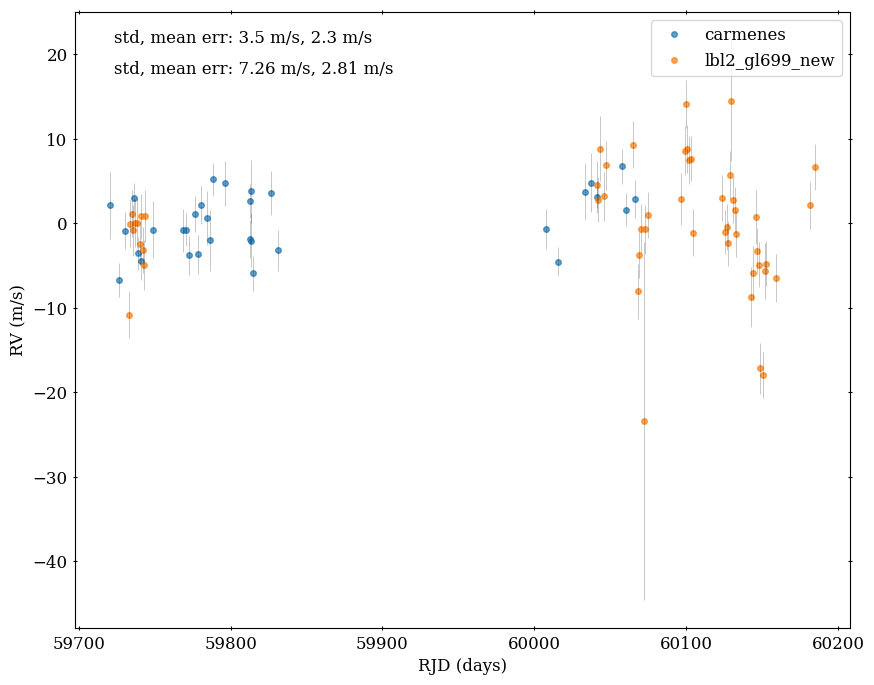

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=4, label=names[i], alpha=0.7)
    ax.errorbar(data['rjd'], data['vrad']-np.median(data['vrad']), yerr=data['svrad'], fmt='o', color='k', ms=0, alpha=0.3, elinewidth=0.5)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.median(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [159]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(32, 3)
(51, 172)


In [160]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[0, 1]


In [161]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

In [162]:
# print the 5 points with largest errorbar
for k, data in enumerate(datasets):
    print(data['svrad'].sort_values(ascending=False).head(5))

0     3.99
19    3.72
14    3.63
27    3.48
26    3.38
Name: svrad, dtype: float64
34    7.152544
13    3.870198
38    3.550901
45    3.309352
17    3.243250
Name: svrad, dtype: float64


In [163]:
# print the 5 points with largest errorbar
# for k, data in enumerate(datasets):
#     print(data['EXTSN035'].sort_values(ascending=True).head(5))

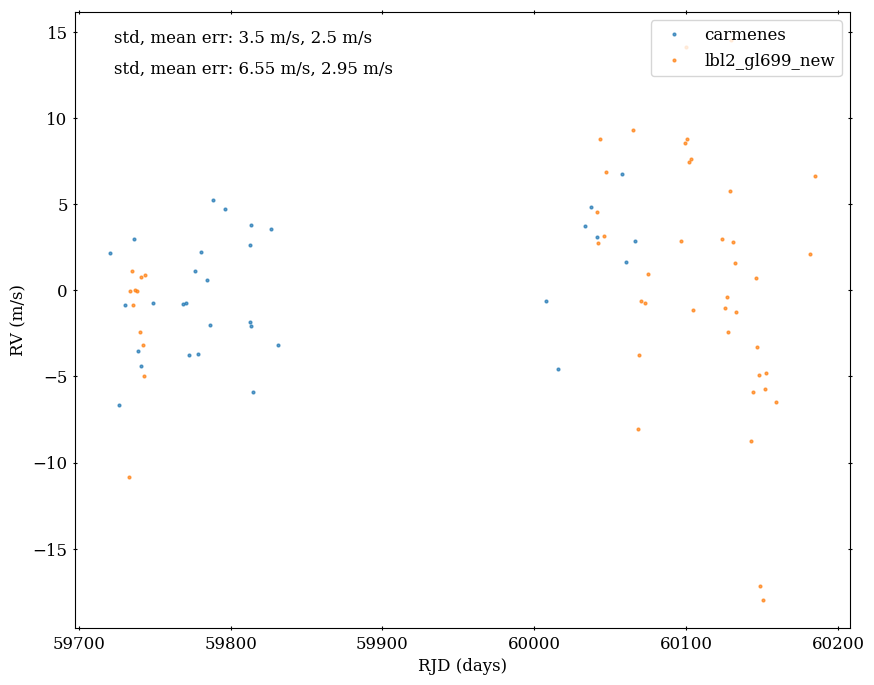

In [164]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [165]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.05]
    faps[k] = ls[k].false_alarm_level(probabilities)

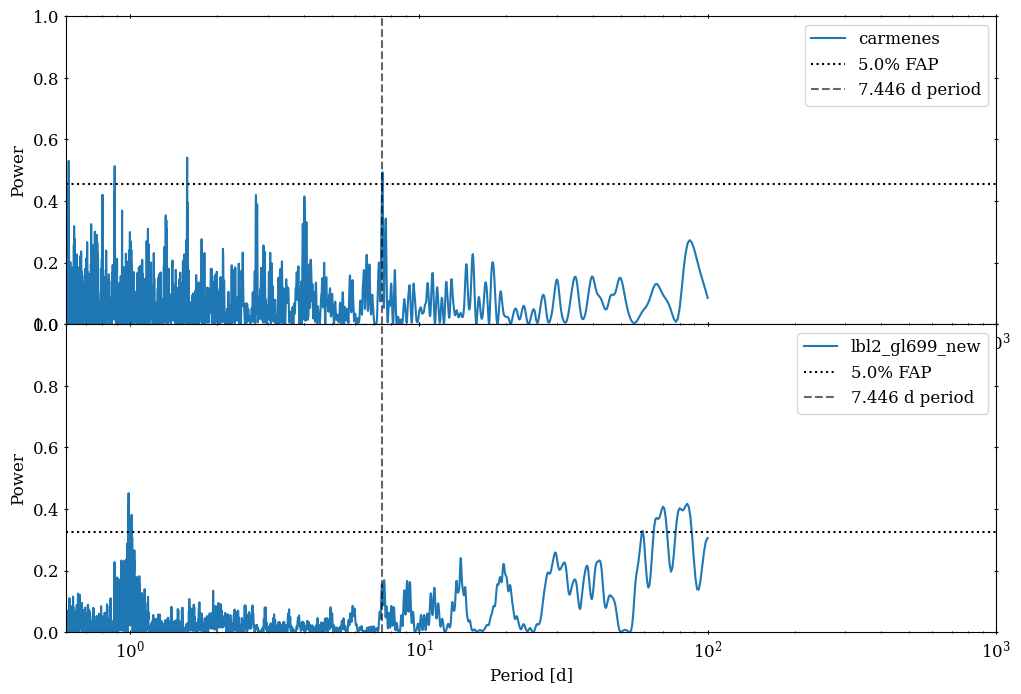

In [166]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 4*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)

# RV fit 

In [167]:
x_ref = dict()
maxrv = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*3

In [168]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        logP = pm.Normal("logP", mu=np.log(period_tess.n), sd=period_tess.s/period_tess.n) #period_tess.s/period_tess.n
        P = pm.Deterministic("P", tt.exp(logP))

        K = pm.Uniform("K", lower=0, upper=maxrv[k])

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=epoch_tess.s)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [169]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -145.28587477273823 -> -52.64696964394021
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -52.64696964394021 -> -52.64696964394021
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -268.9103670902588 -> -137.31068268723538
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -137.31068268723538 -> -137.31068268723538


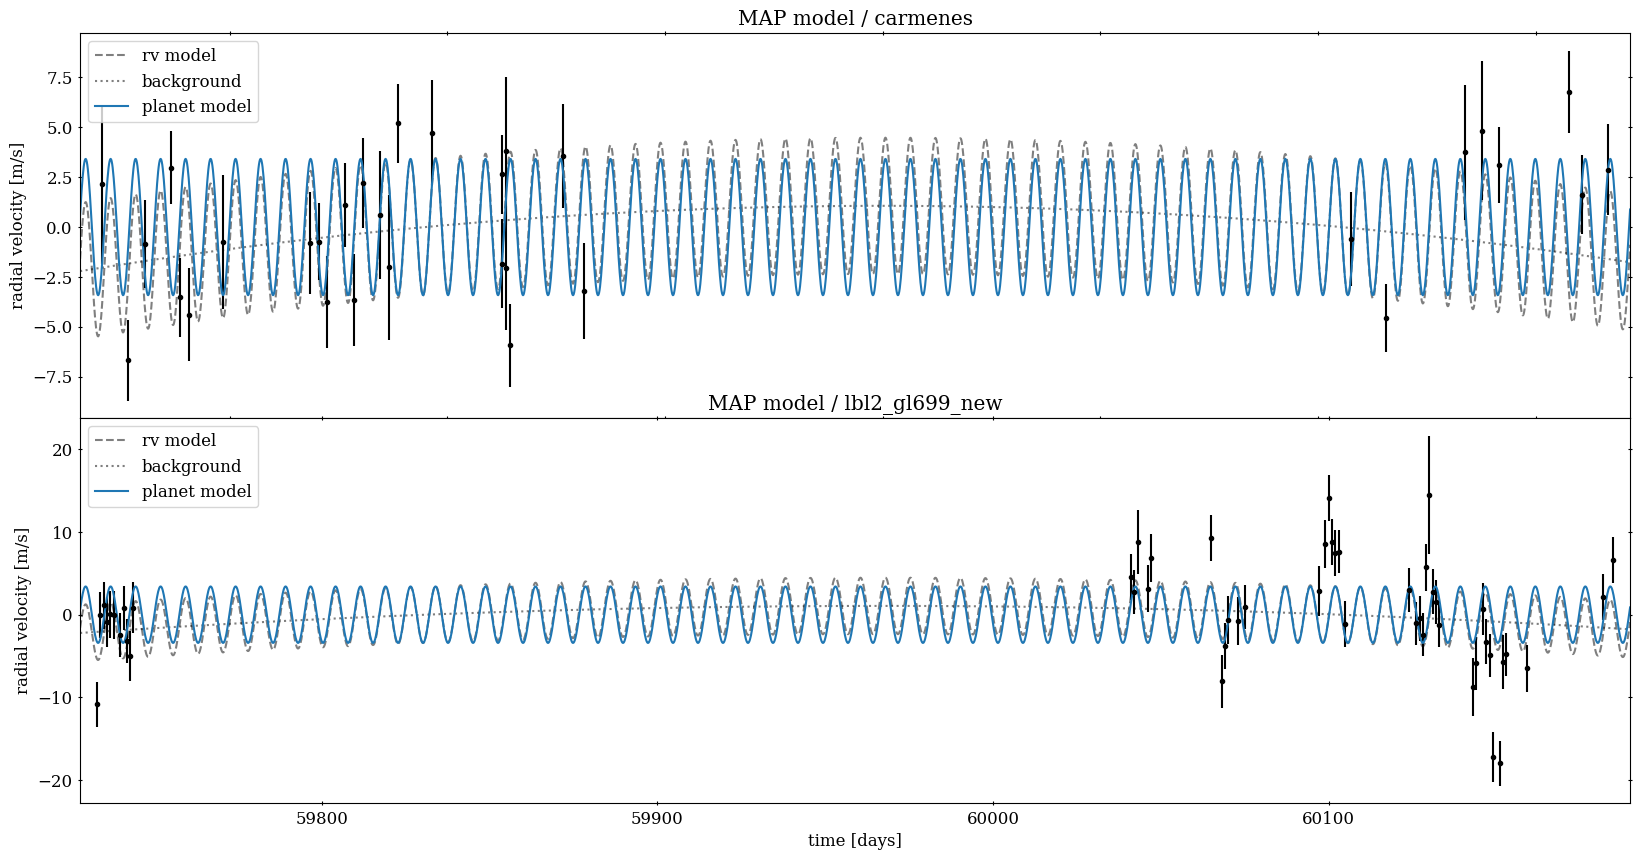

In [170]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [171]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [172]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


4503.463995833333 2643.8209554166665 1.001064
4257.2834105 2755.8865415833334 1.000782


In [173]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.939641e+04,7.520000e-04,5.939641e+04,5.939641e+04,1.100000e-05,8.000000e-06,4891.675243,3151.776325,0.999792,5.939641e+04,7.520000e-04
logP,2.007718e+00,3.000000e-06,2.007708e+00,2.007727e+00,0.000000e+00,0.000000e+00,5152.879580,2848.817905,0.999809,2.007718e+00,3.000000e-06
P,7.446303e+00,2.300000e-05,7.446232e+00,7.446371e+00,0.000000e+00,0.000000e+00,5152.879580,2848.817905,0.999810,7.446303e+00,2.300000e-05
K,3.367379e+00,5.797470e-01,1.574993e+00,5.118102e+00,9.227000e-03,6.525000e-03,4079.605920,2283.411917,1.000179,3.378684e+00,5.796750e-01
logs,-2.746463e+00,2.941718e+00,-1.367307e+01,1.130253e+00,8.444800e-02,5.972800e-02,1318.434629,1493.814238,1.000440,-1.998931e+00,2.941350e+00
trend[0],2.000000e-05,4.200000e-05,-9.500000e-05,1.470000e-04,1.000000e-06,1.000000e-06,4559.759085,3023.066804,0.999829,2.000000e-05,4.200000e-05
trend[1],1.046300e-02,3.461000e-03,8.690000e-04,2.095500e-02,4.900000e-05,3.500000e-05,5067.645011,2748.283867,0.999924,1.043600e-02,3.461000e-03
trend[2],1.431650e-01,7.274120e-01,-2.018934e+00,2.480793e+00,1.097800e-02,1.249600e-02,4388.048863,2597.275909,1.000504,1.440040e-01,7.273210e-01
mstar,3.643990e-01,2.006500e-02,3.066160e-01,4.228170e-01,2.730000e-04,1.950000e-04,5411.667100,2769.447063,1.000106,3.643900e-01,2.006300e-02
rstar,3.762130e-01,1.119200e-02,3.446420e-01,4.091570e-01,1.650000e-04,1.170000e-04,4608.337772,2845.866763,1.001064,3.760540e-01,1.119000e-02


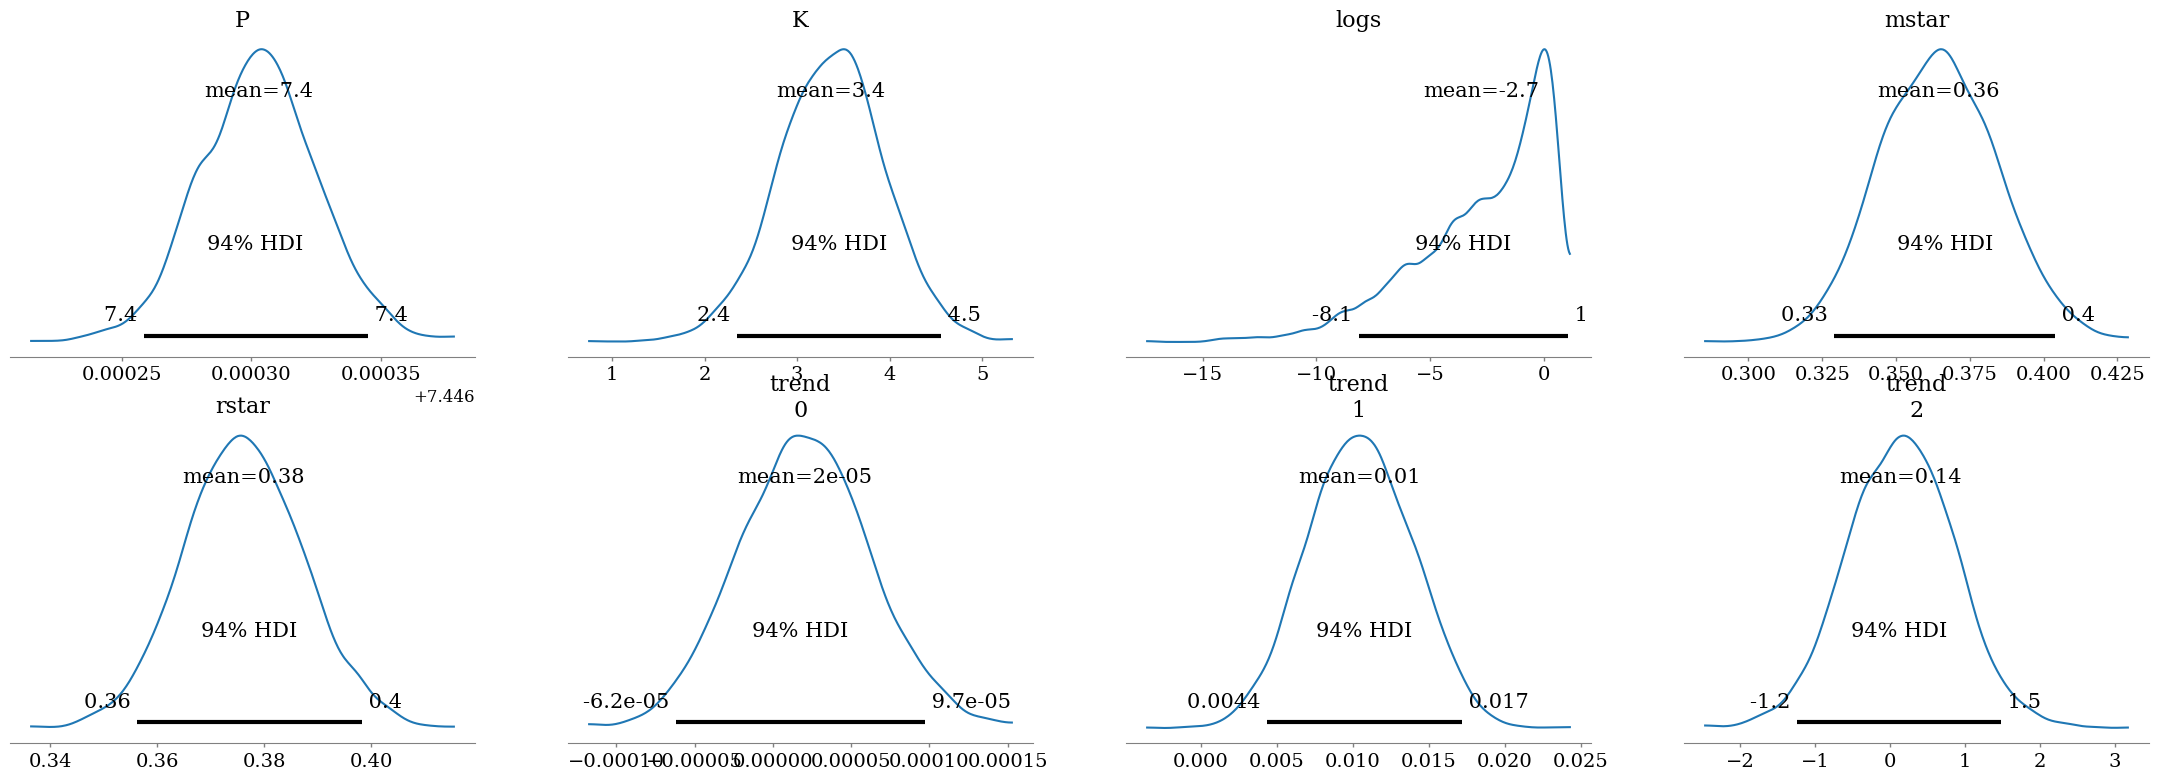

In [174]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [175]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = ufloat((traces[i].posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, (traces[i].posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
    K[i] = ufloat(traces[i].posterior["K"].median().item(), traces[i].posterior["K"].std().item())
    period[i] = ufloat(traces[i].posterior['P'].median().item(),traces[i].posterior['P'].std().item())
    t_0[i] = ufloat(traces[i].posterior['t0'].median().item(), traces[i].posterior['t0'].std().item())
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())
    smaxis[i] = ufloat(traces[i].posterior['a'].median().item(), traces[i].posterior['a'].std().item())
    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))
    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1)
    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)

    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp = {m:.3f} Mearth".format(m=mass[i]))
    print('K = {k:.3f} m/s'.format(k=K[i]))
    print("P = {p:.6f} days".format(p=period[i]))
    print("Epoch = {e:.5f}".format(e=t_0[i]))
    print('a = {a:.4f} AU'.format(a=smaxis[i]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  carmenes
Mp = 5.264+/-0.921 Mearth
K = 3.379+/-0.580 m/s
P = 7.446303+/-0.000023 days
Epoch = 59396.40958+/-0.00075
a = 0.0533+/-0.0010 AU
mstar = 0.364+/-0.020 Msun
rstar = 0.376+/-0.011 Rsun
RV jitter =  0.1+/-0.4
---------------------------------------------
REDUCTION:  lbl2_gl699_new
Mp = 4.868+/-1.773 Mearth
K = 3.139+/-1.132 m/s
P = 7.446303+/-0.000023 days
Epoch = 59396.40958+/-0.00074
a = 0.0533+/-0.0010 AU
mstar = 0.364+/-0.020 Msun
rstar = 0.376+/-0.011 Rsun
RV jitter =  5.0+/-0.7
---------------------------------------------


In [176]:
# REDUCTION:  carmenes
# Mp = 5.238+/-0.936 Mearth
# K = 3.371+/-0.591 m/s
# P = 7.446303+/-0.000023 days
# Epoch = 59396.40956+/-0.00075
# a = 0.0533+/-0.0010 AU
# mstar = 0.364+/-0.020 Msun
# rstar = 0.376+/-0.011 Rsun
# RV jitter =  0.2+/-0.5
# ---------------------------------------------
# REDUCTION:  lbl2_gl699_new
# Mp = 4.930+/-1.734 Mearth
# K = 3.187+/-1.106 m/s
# P = 7.446303+/-0.000023 days
# Epoch = 59396.40956+/-0.00075
# a = 0.0533+/-0.0010 AU
# mstar = 0.364+/-0.020 Msun
# rstar = 0.376+/-0.011 Rsun
# RV jitter =  5.0+/-0.7
# ---------------------------------------------

## Plot results

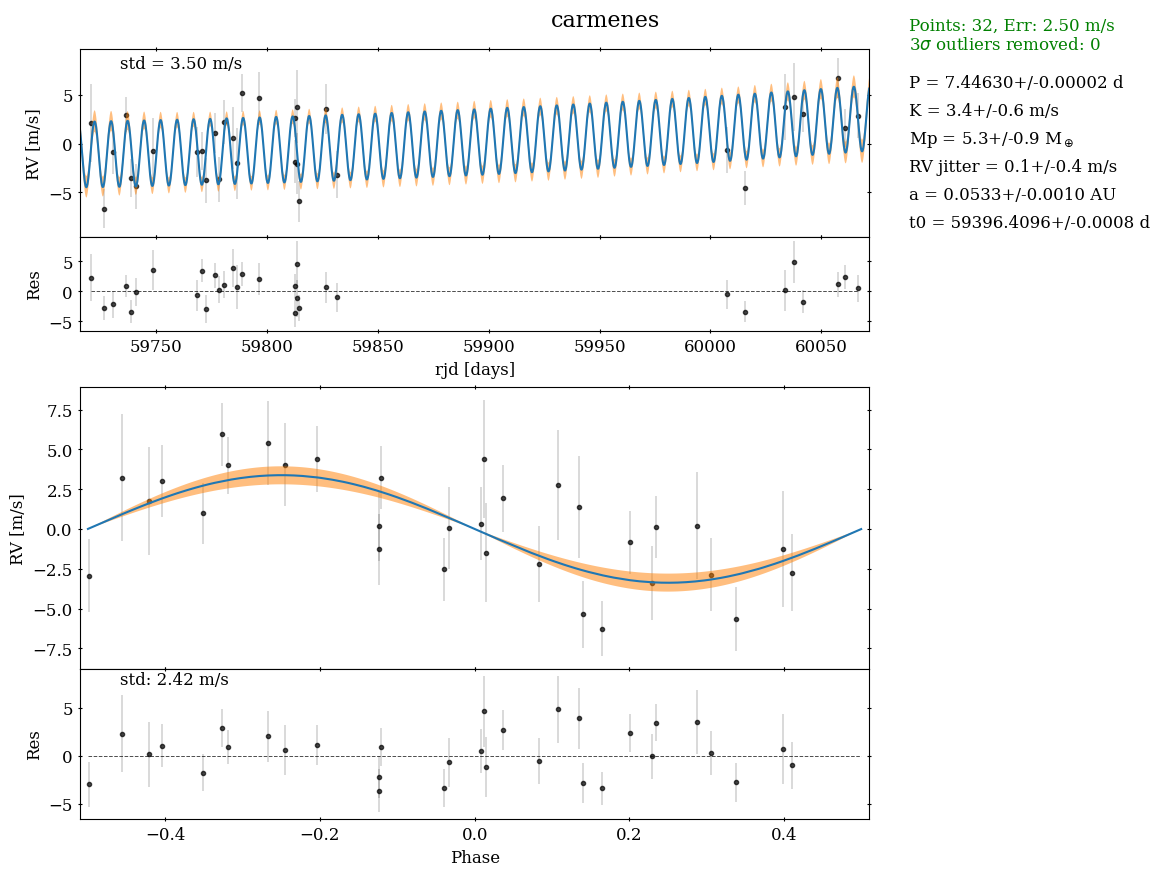

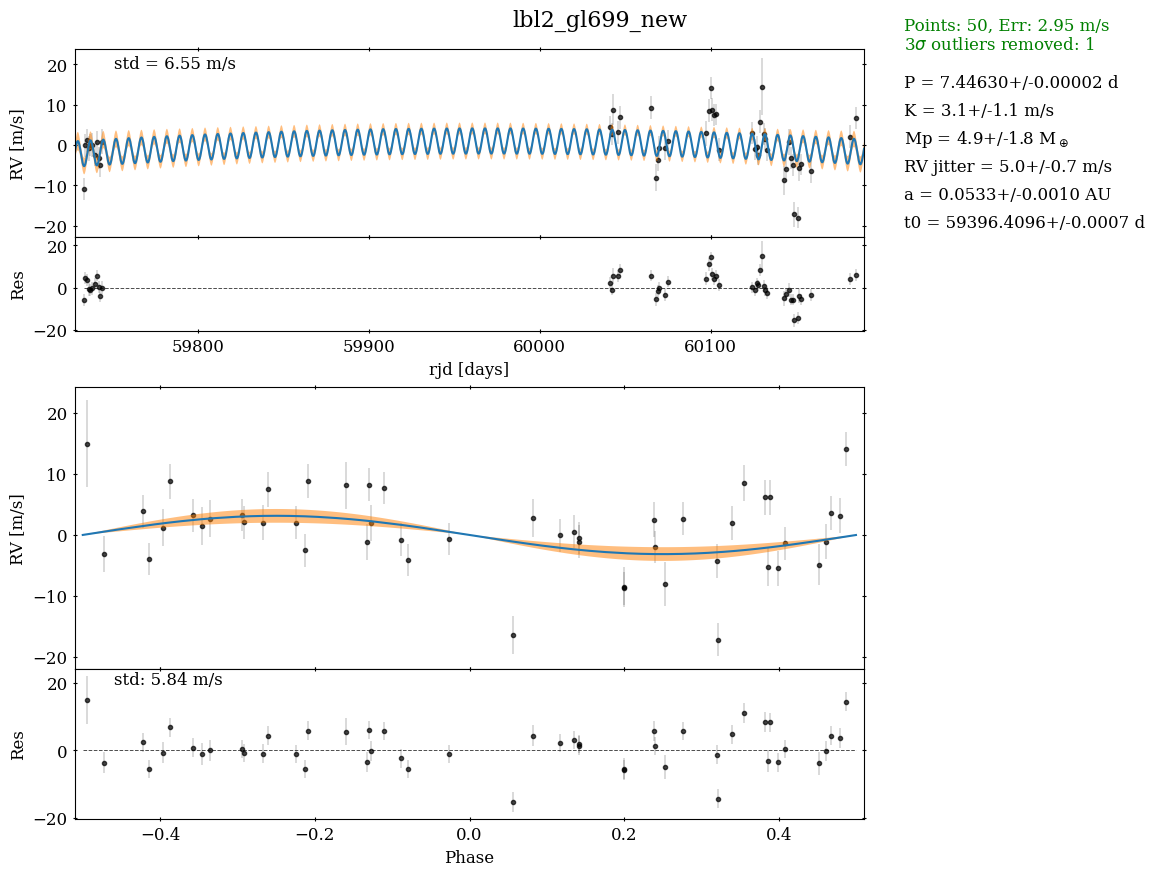

In [177]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.35, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=data['svrad'], fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()